In [1]:
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from dissertation_codes.estimators import KalmanFilter
import dissertation_codes.utils.constants as ct
from dissertation_codes.environment import Particle3D
from control import lqr, dare
from dissertation_codes.utils.parameters import *

In [2]:
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({
    "text.usetex": True,
})

In [12]:
omegas = [2*np.pi*63.10e3, 2*np.pi*70.24e3, 2*np.pi*15.79e3]

B = np.array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]])
radius = 75e-9
wavelength = 1.064e-6
power = 300e-3
p = 1e-7
waist = 0.6e-6
eta_detection = 0.5
delta_t = 1e-9
control_step = 30 
fs = 1/(control_step*delta_t)
gamma, omega, ba_force, std_detection, std_z = compute_parameters_simulation(power, wavelength, waist, 
                                                                      radius, p, fs, eta_detection)

env = Particle3D(omegas, gamma, B, radius=radius)
period = 2*np.pi/omegas[2]
t = np.arange(0, 3 * period, delta_t)
N = t.shape[0]

In [13]:
Q = np.array([[0, 0, 0, 0, 0, 0], 
              [0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0],
              [0, 0, 0, env.thermal_force_std_x**2, 0, 0],
              [0, 0, 0, 0, env.thermal_force_std_y**2, 0],
              [0, 0, 0, 0, 0, env.thermal_force_std_z**2]])*control_step*delta_t/2
R = np.array([[np.power(std_detection/env.zp_x, 2), 0, 0],
              [0, np.power(std_detection/env.zp_y, 2), 0],
              [0, 0, np.power(std_detection/env.zp_z, 2)]])

In [14]:
Ad = scipy.linalg.expm(env.A *control_step*delta_t)
Bd = env.B * delta_t * control_step

In [36]:
g_fb = 0.25
Ad = scipy.linalg.expm(env.A *control_step*delta_t)
Bd = env.B * delta_t * control_step
cost_states = np.array([[omegas[0]/2, 0, 0, 0, 0, 0],
                        [0, omegas[1]/2, 0, 0, 0, 0],
                        [0, 0, omegas[2]/2, 0, 0, 0],
                        [0, 0, 0, omegas[0]/2, 0, 0],
                        [0, 0, 0, 0, omegas[1]/2, 0],
                        [0, 0, 0, 0, 0, omegas[2]/2]])
control_effort = np.array([[1/(2*omegas[0]), 0, 0],
                        [0, 1/(2*omegas[1]), 0],
                        [0, 0, 1/(2*omegas[2])]])
X, L, G = dare(Ad, Bd, cost_states, control_effort/(g_fb**2))
G

array([[ 43323.57563476,      0.        ,      0.        ,
        275804.0337212 ,      0.        ,      0.        ],
       [     0.        ,  47789.51516957,      0.        ,
             0.        , 306932.97811093,      0.        ],
       [     0.        ,      0.        ,  11492.4401573 ,
             0.        ,      0.        ,  69131.63187391]])

In [45]:
x0 = 100
P0 = 100000*np.eye(6)
estimation = np.zeros((6,1))
states = x0*np.random.normal(size=(6,1))
new_states = np.zeros((N, 6))
measured_states = np.zeros((N,3))
estimated_states = np.zeros((N, 6))
estimated_states[0, :] = estimation[:,0]
#estimation = estimation.reshape((2, 1))
control=np.zeros((3,1))
controls = np.zeros((3,t.shape[0]))
kalman = KalmanFilter(estimation, P0, Ad, Bd, env.C, Q, R)
for i in tqdm(range(t.shape[0])):
    new_states[i, :] = states[:, 0]
    if not i % control_step:
        measurement_noise = np.array(
            [np.random.normal()*std_detection/env.zp_x,
            np.random.normal()*std_detection/env.zp_y,
            np.random.normal()*std_detection/env.zp_z]
            )
        measured_states[i,:] = env.C@states[:, 0] + measurement_noise
        kalman.propagate_dynamics(control)
        kalman.compute_aposteriori(measured_states[i].reshape((3,1)))
        estimated_states[i, :] = kalman.estimates_aposteriori[int(i/control_step)][:, 0].reshape((6))
        estimation = estimated_states[i, :].reshape((6, 1))   
        control = -G@estimation
        #print(control.shape)
    else:
        measured_states[i] = measured_states[i-1]
        estimated_states[i, :] = estimated_states[i-1,:]
    controls[:,i] = control[:,0]
    states = env.step(states, control=control, delta_t=delta_t)

  0%|          | 0/189994 [00:00<?, ?it/s]

100%|██████████| 189994/189994 [00:06<00:00, 30417.18it/s]


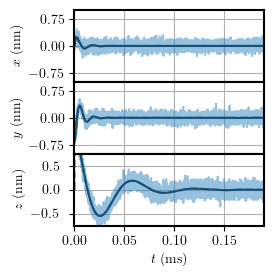

In [57]:
colors = ['#2E86C1', '#85C1E9', '#1B4F72']

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
factor = 0.7
fig.set_size_inches(3.5*factor, 4*factor, forward=True)

ax1.plot(t/1e-3, measured_states[:,0]*env.zp_x/1e-9, color=colors[0], alpha=0.5)
ax1.plot(t/1e-3, new_states[:,0]*env.zp_x/1e-9, color=colors[0], linestyle='dashed')
ax1.plot(t/1e-3, estimated_states[:,0]*env.zp_x/1e-9, color=colors[2])
ax1.set_xlim([0, t.max()/1e-3])
ax1.set_yticks([-0.75, 0, 0.75])
ax1.grid(True, which="both", ls="-")
ax1.set_ylabel(r'$x$ (n$\textrm{m})$')
ax1.set_ylim([-1, 1])



ax2.plot(t/1e-3, measured_states[:,1]*env.zp_y/1e-9, color=colors[0], alpha=0.5)
ax2.plot(t/1e-3, estimated_states[:,1]*env.zp_y/1e-9, color=colors[0], linestyle='dashed')
ax2.plot(t/1e-3, new_states[:,1]*env.zp_y/1e-9, color=colors[2])
ax2.set_ylabel(r'$y$ (n$ \textrm{m})$')
ax2.grid(True, which="both", ls="-")
ax2.set_yticks([-0.75,0,0.75])
ax2.set_ylim([-1, 1])


ax3.plot(t/1e-3, measured_states[:,2]*env.zp_z/1e-9, color=colors[0], alpha=0.5)
ax3.plot(t/1e-3, estimated_states[:,2]*env.zp_z/1e-9, color=colors[0], linestyle='dashed')
ax3.plot(t/1e-3, new_states[:,2]*env.zp_z/1e-9, color=colors[2])
ax3.set_ylabel(r'$z$ (n$\textrm{m})$')
ax3.set_xlabel(r'$t$ (ms)')
ax3.set_ylim([-0.75, 0.75])
#ax3.set_yticks([-1.50,0,1.50])
ax3.tick_params(axis='y', pad=7)

plt.subplots_adjust(wspace=0, hspace=0)
plt.grid()
plt.savefig('../../plots/Chapter 3/lqg_control_pos.pdf', dpi=300, bbox_inches = 'tight')
plt.show()


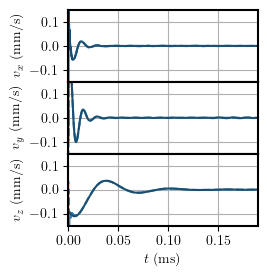

In [70]:
colors = ['#2E86C1', '#85C1E9', '#1B4F72']

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
factor = 0.7
fig.set_size_inches(3.5*factor, 4*factor, forward=True)

ax1.plot(t/1e-3, new_states[:,3]*env.zp_px/(env._m_*1e-3), color=colors[0], linestyle='dashed')
ax1.plot(t/1e-3, estimated_states[:,3]*env.zp_px/(env._m_*1e-3), color=colors[2])
ax1.set_xlim([0, t.max()/1e-3])
ax1.grid(True, which="both", ls="-")
ax1.set_ylabel(r'$v_x$ ($\textrm{mm/s})$')
ax1.set_yticks([-0.1,0,0.1])
ax1.set_ylim([-0.15, 0.15])


ax2.plot(t/1e-3, estimated_states[:,4]*env.zp_py/(env._m_*1e-3), color=colors[0], linestyle='dashed')
ax2.plot(t/1e-3, new_states[:,4]*env.zp_py/(env._m_*1e-3), color=colors[2])
ax2.set_ylabel(r'$v_y$ ($ \textrm{mm/s})$')
ax2.grid(True, which="both", ls="-")
ax2.set_yticks([-0.1,0,0.1])
ax2.set_ylim([-0.15, 0.15])


ax3.plot(t/1e-3, estimated_states[:, 5]*env.zp_pz/(env._m_*1e-3), color=colors[0], linestyle='dashed')
ax3.plot(t/1e-3, new_states[:, 5]*env.zp_pz/(env._m_*1e-3), color=colors[2])
ax3.set_ylabel(r'$v_z$ ($\textrm{mm/s})$')
ax3.set_xlabel(r'$t$ (ms)')
ax3.set_ylim([-0.15, 0.15])
#ax3.set_yticks([-1.50,0,1.50])
#ax3.tick_params(axis='y', pad=7)

plt.subplots_adjust(wspace=0, hspace=0)
plt.grid()
plt.savefig('../../plots/Chapter 3/lqg_control_vel.pdf', dpi=300, bbox_inches = 'tight')
plt.show()